## 환경설정
- LightGBM의 GPU를 설정하려면 아래 스크립트 선 실행하시기를 바랍니다. 
- 본 실습은 학습 시간이 매우 오래 소요 됩니다 (약 4-5시간 소요 예상). 그런 경우에는 아래 URL을 참고하셔서 코랩을 장시간 이용할 수 있도록 설정을 해야 합니다. 
  + https://naenjun.tistory.com/18
```
function ClickConnect() {
    var buttons = document.querySelectorAll("colab-dialog.yes-no-dialog paper-button#cancel"); 
    buttons.forEach(function(btn) { 
        btn.click(); 
    }); 
    console.log("1분마다 자동 재연결"); 
    document.querySelector("colab-toolbar-button#connect").click(); 
} 
setInterval(ClickConnect,1000*60);
```

- 학습 시간이 길어서, LightGBM 이후 부터는 GPU로 학습할 수 있도록 변경하였습니다). 

In [1]:
!git clone --recursive https://github.com/Microsoft/LightGBM
%cd LightGBM
!mkdir build
!cmake -DUSE_GPU=1
!make -j$(nproc)
!sudo apt-get -y install python-pip
!sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
%cd /content/LightGBM/python-package
!sudo python setup.py install
!pip3 uninstall scikit-learn
!pip3 install scikit-learn==0.21.3

Cloning into 'LightGBM'...
remote: Enumerating objects: 22143, done.
remote: Counting objects: 100% (689/689), done.
remote: Compressing objects: 100% (426/426), done.
remote: Total 22143 (delta 412), reused 432 (delta 251), pack-reused 21454
Receiving objects: 100% (22143/22143), 17.54 MiB | 29.98 MiB/s, done.
Resolving deltas: 100% (16122/16122), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/LightGBM/external_libs/compute'...
remote: Enumerating objects: 21728, done.        
remote: Total 21728 (delta 0), reused 0 (delta 0), pack-reused

## Kaggle 


In [2]:
!pip install kaggle

- LightGBM GPU를 사용하기 위해 [런타임]-[런타임 다시 시작]을 진행합니다. 
- 런타임 다시 시작 후에는 아래 코드부터 실행하시면 됩니다. 
- 2021.5.30일 기준 정상적으로 작동되었습니다. by 집필진

In [1]:
import sklearn
print(sklearn.__version__)

0.21.3


In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


In [3]:
!kaggle competitions download -c sf-crime

 81% 18.0M/22.1M [00:00<00:00, 36.7MB/s]
100% 22.1M/22.1M [00:00<00:00, 73.8MB/s]
 27% 5.00M/18.7M [00:00<00:00, 32.3MB/s]
100% 18.7M/18.7M [00:00<00:00, 74.1MB/s]
  0% 0.00/2.35M [00:00<?, ?B/s]
100% 2.35M/2.35M [00:00<00:00, 159MB/s]


In [ ]:
!ls

LightGBM  sample_data  sampleSubmission.csv.zip  test.csv.zip  train.csv.zip


In [4]:
!unzip '*.zip'

Archive:  sampleSubmission.csv.zip
  inflating: sampleSubmission.csv    

Archive:  train.csv.zip
  inflating: train.csv               

Archive:  test.csv.zip
  inflating: test.csv                

3 archives were successfully processed.


In [ ]:
import os 
DATA_PATH = "./"
for file in os.listdir(DATA_PATH):
  if 'csv' in file and 'zip' not in file:
    print(file.ljust(30) + str(round(os.path.getsize(file) / 1000000, 2)) + 'MB')

sampleSubmission.csv          75.05MB
test.csv                      91.0MB
train.csv                     127.43MB


## 데이터 확인

In [5]:
import pandas as pd
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print('Data Loading is done!')

Data Loading is done!


In [ ]:
train.shape, test.shape

((878049, 9), (884262, 7))

In [ ]:
print("Y > 90:", test.loc[test.Y > 90].count()[0])
print("Y < 90:", test.loc[test.Y < 90].count()[0])

Y > 90: 0
Y < 90: 884186


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dates       878049 non-null  object 
 1   Category    878049 non-null  object 
 2   Descript    878049 non-null  object 
 3   DayOfWeek   878049 non-null  object 
 4   PdDistrict  878049 non-null  object 
 5   Resolution  878049 non-null  object 
 6   Address     878049 non-null  object 
 7   X           878049 non-null  float64
 8   Y           878049 non-null  float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884262 entries, 0 to 884261
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Id          884262 non-null  int64  
 1   Dates       884262 non-null  object 
 2   DayOfWeek   884262 non-null  object 
 3   PdDistrict  884262 non-null  object 
 4   Address     884262 non-null  object 
 5   X           884262 non-null  float64
 6   Y           884262 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 47.2+ MB


In [6]:
sample = pd.read_csv('sampleSubmission.csv')
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884262 entries, 0 to 884261
Data columns (total 40 columns):
 #   Column                       Non-Null Count   Dtype
---  ------                       --------------   -----
 0   Id                           884262 non-null  int64
 1   ARSON                        884262 non-null  int64
 2   ASSAULT                      884262 non-null  int64
 3   BAD CHECKS                   884262 non-null  int64
 4   BRIBERY                      884262 non-null  int64
 5   BURGLARY                     884262 non-null  int64
 6   DISORDERLY CONDUCT           884262 non-null  int64
 7   DRIVING UNDER THE INFLUENCE  884262 non-null  int64
 8   DRUG/NARCOTIC                884262 non-null  int64
 9   DRUNKENNESS                  884262 non-null  int64
 10  EMBEZZLEMENT                 884262 non-null  int64
 11  EXTORTION                    884262 non-null  int64
 12  FAMILY OFFENSES              884262 non-null  int64
 13  FORGERY/COUNTERFEITING       

In [ ]:
sample.head(5)

Id  ARSON  ASSAULT  ...  VEHICLE THEFT  WARRANTS  WEAPON LAWS
0   0      0        0  ...              0         1            0
1   1      0        0  ...              0         1            0
2   2      0        0  ...              0         1            0
3   3      0        0  ...              0         1            0
4   4      0        0  ...              0         1            0

[5 rows x 40 columns]

In [7]:
# train copy
train_df = train.copy()
train_df.shape == train.shape

True

### 결측치 확인

In [8]:
def check_na(data):
  isnull_na = (data.isnull().sum() / len(data)) * 100
  data_na = isnull_na.drop(isnull_na[isnull_na == 0].index).sort_values(ascending=False)
  missing_data = pd.DataFrame({'Missing Ratio' :data_na, 
                               'Data Type': data.dtypes[data_na.index]})
  print("결측치 데이터 컬럼과 건수:\n", missing_data)

check_na(train_df)

결측치 데이터 컬럼과 건수:
 Empty DataFrame
Columns: [Missing Ratio, Data Type]
Index: []


### 중복 변수 제거

In [9]:
train_df.duplicated().sum()

2323

In [10]:
print("Before:", train_df.shape)
train_df.drop_duplicates(inplace=True)
print("After:", train_df.shape)

Before: (878049, 9)
After: (875726, 9)


### Descript, Resolution 변수 삭제

In [11]:
train_df.drop(['Descript', 'Resolution'], axis = 1, inplace=True)
train_df.shape

(875726, 7)

In [12]:
train_df.head()

Dates        Category  ...           X          Y
0  2015-05-13 23:53:00        WARRANTS  ... -122.425892  37.774599
1  2015-05-13 23:53:00  OTHER OFFENSES  ... -122.425892  37.774599
2  2015-05-13 23:33:00  OTHER OFFENSES  ... -122.424363  37.800414
3  2015-05-13 23:30:00   LARCENY/THEFT  ... -122.426995  37.800873
4  2015-05-13 23:30:00   LARCENY/THEFT  ... -122.438738  37.771541

[5 rows x 7 columns]

### 종속변수 Category 확인

In [13]:
train_df['Category'].value_counts()[:5]

LARCENY/THEFT     174320
OTHER OFFENSES    125960
NON-CRIMINAL       91915
ASSAULT            76815
DRUG/NARCOTIC      53919
Name: Category, dtype: int64

In [14]:
train_df['Category'].value_counts()[-5:]

EXTORTION                    256
SEX OFFENSES NON FORCIBLE    148
GAMBLING                     146
PORNOGRAPHY/OBSCENE MAT       22
TREA                           6
Name: Category, dtype: int64

### 독립변수 DayOfWeek 확인

In [15]:
temp = train_df.groupby('DayOfWeek').count().iloc[:, 0]
temp = temp.reindex([
  'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'            
])

print(temp)

DayOfWeek
Monday       121303
Tuesday      124603
Wednesday    128829
Thursday     124757
Friday       133371
Saturday     126469
Sunday       116394
Name: Dates, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


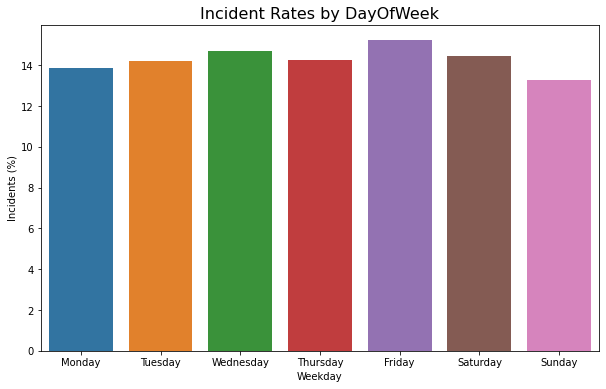

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
import numpy as np

fig, ax = plt.subplots(figsize=(10, 6))

ax = sns.barplot(
    temp.index, (temp.values / temp.values.sum()) * 100,
    orient='v')

ax.set_title('Incident Rates by DayOfWeek', fontdict={'fontsize': 16})
ax.set_xlabel('Weekday')
ax.set_ylabel('Incidents (%)')

plt.show()

In [17]:
print("DayOfWeek Incident for each category in percentage\n")
for idx, data in enumerate(train_df.groupby(["Category"])["DayOfWeek"]):

  print("The Current index is:", data[0])
  print(round(data[1].value_counts()/data[1].count()*100,1))
  print()

  if idx == 1:
    break

DayOfWeek Incident for each category in percentage

The Current index is: ARSON
Tuesday      15.5
Monday       15.1
Friday       14.6
Saturday     14.5
Sunday       14.0
Wednesday    13.2
Thursday     13.2
Name: DayOfWeek, dtype: float64

The Current index is: ASSAULT
Sunday       15.7
Saturday     15.6
Friday       14.5
Monday       13.7
Wednesday    13.7
Tuesday      13.4
Thursday     13.3
Name: DayOfWeek, dtype: float64



In [18]:
temp = train_df.groupby('PdDistrict').count().iloc[:, 0]
print(temp)

PdDistrict
BAYVIEW        89098
CENTRAL        85267
INGLESIDE      78722
MISSION       119723
NORTHERN      105105
PARK           49161
RICHMOND       45080
SOUTHERN      156528
TARAVAL        65400
TENDERLOIN     81642
Name: Dates, dtype: int64


### 독립변수 PdDistrict 확인

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


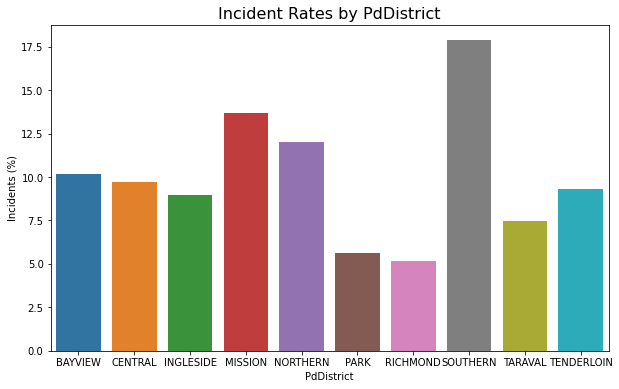

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))

ax = sns.barplot(
    temp.index, (temp.values / temp.values.sum()) * 100,
    orient='v')

ax.set_title('Incident Rates by PdDistrict', fontdict={'fontsize': 16})
ax.set_xlabel('PdDistrict')
ax.set_ylabel('Incidents (%)')

plt.show()

In [20]:
print("PdDistrict Incident for each category in percentage\n")
for idx, data in enumerate(train_df.groupby(["Category"])["PdDistrict"]):

  print("The Current index is:", data[0])
  print(round(data[1].value_counts()/data[1].count()*100,1))
  print()

  if idx == 1:
    break

PdDistrict Incident for each category in percentage

The Current index is: ARSON
BAYVIEW       26.0
SOUTHERN      12.2
INGLESIDE     12.0
NORTHERN       9.9
MISSION        9.5
TARAVAL        7.9
CENTRAL        7.3
RICHMOND       6.8
PARK           4.3
TENDERLOIN     4.0
Name: PdDistrict, dtype: float64

The Current index is: ASSAULT
SOUTHERN      15.8
MISSION       14.5
BAYVIEW       12.8
INGLESIDE     11.1
NORTHERN      10.8
TENDERLOIN    10.0
CENTRAL        9.1
TARAVAL        7.1
PARK           4.6
RICHMOND       4.2
Name: PdDistrict, dtype: float64



### 독립변수 x와 y 확인
- X - Longitude
- Y - Latitude

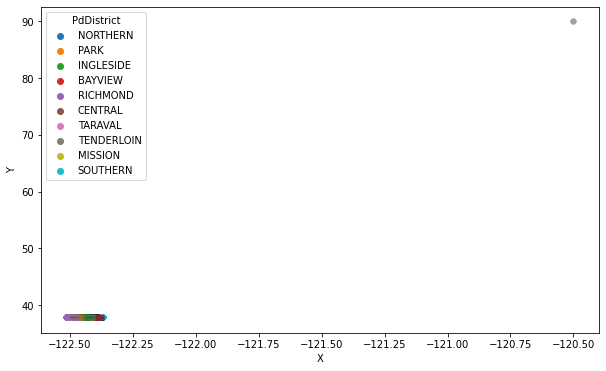

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x = "X", y="Y", data=train_df, alpha=0.01, hue = "PdDistrict", ax = ax)

plt.show()

- 샌프란시스코의 지도에서 위도 경도 이상치를 확인하도록 합니다. 

In [22]:
print("Y > 40:", train_df.loc[train.Y > 40].count()[0])
print("Y < 40:", train_df.loc[train.Y < 40].count()[0])

Y > 40: 67
Y < 40: 875659


In [23]:
train_df.loc[train.Y > 50].sample(5)

Dates            Category  ...      X     Y
767502  2004-06-24 00:03:00      OTHER OFFENSES  ... -120.5  90.0
671709  2005-11-02 20:30:00      OTHER OFFENSES  ... -120.5  90.0
687527  2005-08-13 17:00:00       VEHICLE THEFT  ... -120.5  90.0
767501  2004-06-24 00:03:00  DISORDERLY CONDUCT  ... -120.5  90.0
682780  2005-09-09 00:03:00             ASSAULT  ... -120.5  90.0

[5 rows x 7 columns]

In [24]:
print(train_df.shape)
train_df = train_df[train_df["Y"] < 40]
print(train_df.shape)

(875726, 7)
(875659, 7)


/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


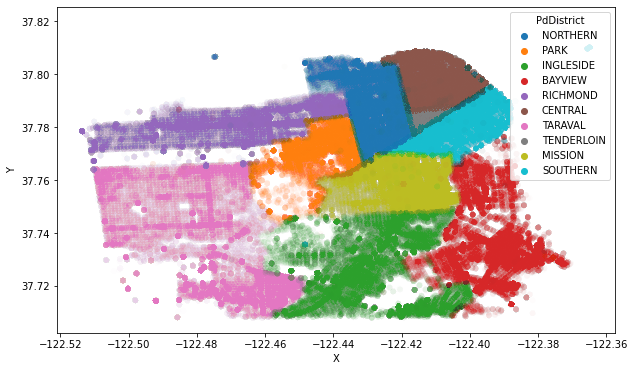

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x = "X", y="Y", data=train_df, alpha=0.01, hue = "PdDistrict", ax = ax)

plt.show()

In [26]:
theft_df = train_df[train_df['Category'] == 'LARCENY/THEFT']
theft_df.shape

(174305, 7)

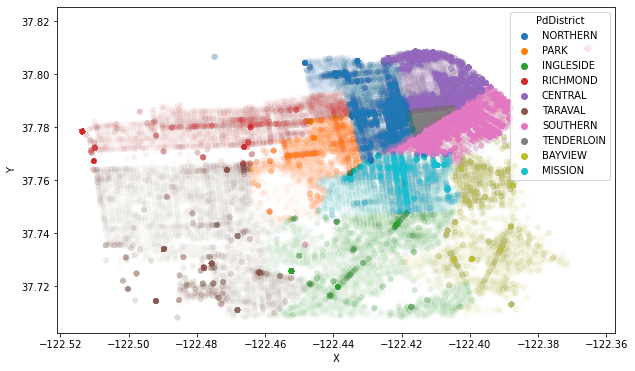

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x = "X", y="Y", data=theft_df, alpha=0.01, hue = "PdDistrict", ax = ax)

plt.show()

### 독립변수 Dates 확인

In [28]:
train_df['Dates'].dtypes

dtype('O')

In [29]:
train_df['Dates']= pd.to_datetime(train_df['Dates'])
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 875659 entries, 0 to 878048
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Dates       875659 non-null  datetime64[ns]
 1   Category    875659 non-null  object        
 2   DayOfWeek   875659 non-null  object        
 3   PdDistrict  875659 non-null  object        
 4   Address     875659 non-null  object        
 5   X           875659 non-null  float64       
 6   Y           875659 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 53.4+ MB


In [30]:
train_df['Dates'].sample(1)

420521   2009-06-12 20:00:00
Name: Dates, dtype: datetime64[ns]

In [31]:
# convert
train_df['Dates']= pd.to_datetime(train_df['Dates'])
train_df['Date'] = train_df.Dates.dt.date
train_df['Hour'] = train_df.Dates.dt.hour
daily_df = train_df.groupby('Date').count().iloc[:, 0]
daily_df

Date
2003-01-06    400
2003-01-07    417
2003-01-08    523
2003-01-09    416
2003-01-10    397
             ... 
2015-05-02    376
2015-05-03    375
2015-05-11    425
2015-05-12    330
2015-05-13    362
Name: Dates, Length: 2249, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


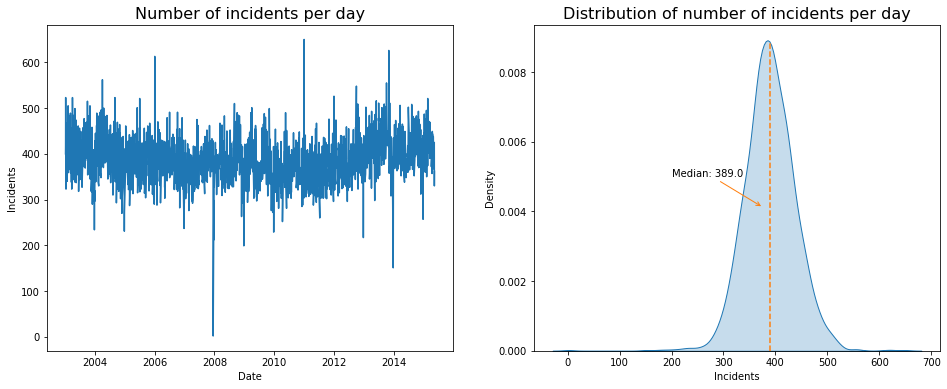

In [32]:
col = sns.color_palette()

fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
sns.lineplot(daily_df.index, daily_df.values, ax=ax[0])
ax[0].set_title(
    'Number of incidents per day', fontdict={'fontsize': 16})
ax[0].set_ylabel('Incidents')

sns.kdeplot(data=daily_df, shade=True, ax=ax[1])
ax[1].axvline(x=daily_df.median(), ymax=0.95, linestyle='--', color=col[1])
ax[1].annotate(
    'Median: ' + str(daily_df.median()),
    xy=(daily_df.median(), 0.004),
    xytext=(200, 0.005),
    arrowprops=dict(arrowstyle='->', color=col[1], shrinkB=10))
ax[1].set_title(
    'Distribution of number of incidents per day', fontdict={'fontsize': 16})
ax[1].set_xlabel('Incidents')
ax[1].set_ylabel('Density')

plt.show()

In [33]:
print("The minimum Incident day:\n", daily_df[daily_df.values == min(daily_df.values)])
print("The Maximum Incident day:\n", daily_df[daily_df.values == max(daily_df.values)])

The minimum Incident day:
 Date
2007-12-16    2
Name: Dates, dtype: int64
The Maximum Incident day:
 Date
2011-01-01    650
Name: Dates, dtype: int64


The minimum Incident hour:
 Hour
5    8609
Name: Dates, dtype: int64
The Maximum Incident hour:
 Hour
18    54969
Name: Dates, dtype: int64


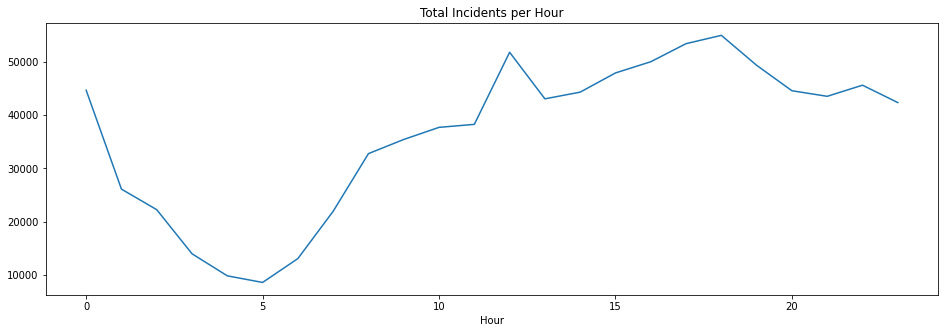

In [34]:
hour_df = train_df.groupby('Hour').count().iloc[:, 0]
print("The minimum Incident hour:\n", hour_df[hour_df.values == min(hour_df.values)])
print("The Maximum Incident hour:\n", hour_df[hour_df.values == max(hour_df.values)])

fig, ax = plt.subplots(figsize=(16, 5))
ax = sns.lineplot(x = hour_df.index, y = hour_df.values)
plt.title('Total Incidents per Hour')
plt.show()

### Benchmark

In [35]:
import numpy as np

naive_vals = train.groupby('Category').count().iloc[:,0]/train.shape[0]
n_rows = test.shape[0]

submission = pd.DataFrame(
    np.repeat(np.array(naive_vals), n_rows).reshape(39, n_rows).transpose(),
    columns=naive_vals.index)

In [36]:
submission.to_csv('baseline_submission.csv', index_label="Id")

In [37]:
!kaggle competitions submit -c sf-crime -f baseline_submission.csv -m "Message"

100% 701M/701M [00:14<00:00, 50.8MB/s]
Successfully submitted to San Francisco Crime Classification

### Feature Engineering


In [38]:
def feature_engineering(data):

  # common
  data.drop_duplicates(inplace=True)
  data['Dates']= pd.to_datetime(data['Dates'])
  data['Date'] = pd.to_datetime(data['Dates'].dt.date)
  data['DayOfWeek'] = data['Dates'].dt.weekday
  data['Month'] = data['Dates'].dt.month 
  data['Year'] = data['Dates'].dt.year
  data['Hour'] = data['Dates'].dt.hour
  
  data.drop(columns=['Dates', 'Date', 'Address'], inplace=True)

  if "Id" in data.columns:
    # Test Data
    data.drop(['Id'], axis=1, inplace=True)
  else:
    # Train Data
    data.drop(['Descript', 'Resolution'], axis=1, inplace=True)

  return data

In [39]:
train = feature_engineering(train)
test = feature_engineering(test)
train.shape, test.shape

((875726, 8), (884262, 7))

In [40]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 875726 entries, 0 to 878048
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Category    875726 non-null  object 
 1   DayOfWeek   875726 non-null  int64  
 2   PdDistrict  875726 non-null  object 
 3   X           875726 non-null  float64
 4   Y           875726 non-null  float64
 5   Month       875726 non-null  int64  
 6   Year        875726 non-null  int64  
 7   Hour        875726 non-null  int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 60.1+ MB


In [41]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le1 = LabelEncoder()
train['PdDistrict'] = le1.fit_transform(train['PdDistrict'])
test['PdDistrict'] = le1.transform(test['PdDistrict'])
le2 = LabelEncoder()

X = train.drop(columns=['Category'])
y = le2.fit_transform(train['Category'])

## Modeling - LightGBM

### Base Model

In [ ]:
import lightgbm as lgb

train_set = lgb.Dataset(
    X, label=y, categorical_feature=['PdDistrict'], free_raw_data=False)

params = {'objective': "multiclass", 
          'num_class': 39, 
          'device':'gpu'}

lgbm_b0 = lgb.train(params, train_set, num_boost_round=6)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1696: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 875726, number of used features: 7
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 7 dense feature groups (6.68 MB) transferred to GPU in 0.016147 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -6.361620
[LightGBM] [Info] Start training from score -2.433653
[LightGBM] [Info] Start training from score -7.676455
[LightGBM] [Info] Start training from score -8.016382
[LightGBM] [Info] Start training from score -3.175005
[LightGBM] [Info] Start training from score -5.313420
[LightGBM] [Info] Start training from score -5.956155
[LightGBM] [Info] Start training from score -2.787570
[LightGBM] [Info] Start training from score -5.321801
[Li

In [ ]:
preds = lgbm_b0.predict(test)
preds

array([[0.00237486, 0.10450819, 0.00033066, ..., 0.08057947, 0.04474527,
        0.0144272 ],
       [0.00217298, 0.09967734, 0.00030255, ..., 0.06171951, 0.05399039,
        0.01454658],
       [0.00135   , 0.06767324, 0.00028838, ..., 0.06105942, 0.03664574,
        0.00728569],
       ...,
       [0.0028283 , 0.09077408, 0.00107053, ..., 0.11202066, 0.04141817,
        0.01116101],
       [0.00454346, 0.09021316, 0.00102916, ..., 0.08764625, 0.04834518,
        0.01173653],
       [0.00195022, 0.07344499, 0.00092518, ..., 0.09681135, 0.02959955,
        0.0071278 ]])

In [ ]:
submission = pd.DataFrame(preds,
                          columns=le2.classes_,
                          index=test.index)
submission.to_csv('LGBM_base_model.csv', index_label='Id')

In [ ]:
!kaggle competitions submit -c sf-crime -f LGBM_base_model.csv -m "Message"

100% 702M/702M [00:42<00:00, 17.5MB/s]
Successfully submitted to San Francisco Crime Classification

### 최적의 파라미터 찾기

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((700580, 7), (175146, 7), (700580,), (175146,))

In [ ]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
import timeit
start_time = timeit.default_timer()

params = {'max_depth': [5, 7], 
          'min_child_weight': [1, 3]
          }

lgbm = LGBMClassifier(objective="multiclass", num_class=39, device="gpu")
gridcv = GridSearchCV(estimator=lgbm,
                      param_grid=params, 
                      n_jobs = -1, 
                      verbose=10,
                      cv = 2,
                      refit = True)

gridcv.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_train, y_train), (X_val, y_val)])

gridcv_df = pd.DataFrame(gridcv.cv_results_)
gridcv_df.loc[:, ['mean_test_score', "params"]]

terminate_time = timeit.default_timer()
print("%f초 걸렸습니다." % (terminate_time - start_time))

Fitting 2 folds for each of 4 candidates, totalling 8 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your cu

[1]	training's multi_logloss: 2.62199	valid_1's multi_logloss: 2.62304
Training until validation scores don't improve for 5 rounds
[2]	training's multi_logloss: 2.58931	valid_1's multi_logloss: 2.59192
[3]	training's multi_logloss: 2.58023	valid_1's multi_logloss: 2.5829
[4]	training's multi_logloss: 2.5562	valid_1's multi_logloss: 2.56036
[5]	training's multi_logloss: 2.54967	valid_1's multi_logloss: 2.5552
[6]	training's multi_logloss: 2.5289	valid_1's multi_logloss: 2.5339
[7]	training's multi_logloss: 2.50934	valid_1's multi_logloss: 2.51571
[8]	training's multi_logloss: 2.4997	valid_1's multi_logloss: 2.50728
[9]	training's multi_logloss: 2.4938	valid_1's multi_logloss: 2.50072
[10]	training's multi_logloss: 2.48753	valid_1's multi_logloss: 2.4958
[11]	training's multi_logloss: 2.48348	valid_1's multi_logloss: 2.49187
[12]	training's multi_logloss: 2.47162	valid_1's multi_logloss: 2.48094
[13]	training's multi_logloss: 2.46424	valid_1's multi_logloss: 2.47468
[14]	training's multi

In [ ]:
gridcv_df

mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
0     543.619575      1.211858  ...        0.000091                4
1     531.614134      0.781542  ...        0.000428                3
2     538.306863      1.293469  ...        0.000142                1
3     544.435804      0.787008  ...        0.000291                2

[4 rows x 12 columns]

In [ ]:
print("\n The best parameters:\n", 
      gridcv.best_params_)


 The best parameters:
 {'max_depth': 7, 'min_child_weight': 1}


### Final Model

In [ ]:
import lightgbm as lgb
import timeit
start_time = timeit.default_timer()

params = {'max_depth': 7, 
          'min_child_weight': 1, 
          'num_leaves': 300, 
          'objective': "multiclass",
          'num_class': 39,
          'device': 'gpu',
          'n_jobs':-1}

lgtrain, lgval = lgb.Dataset(X_train, y_train), lgb.Dataset(X_val, y_val)
lgbmodel = lgb.train(params, 
                     lgtrain, 
                     100, 
                     valid_sets=[lgtrain, lgval],
                     early_stopping_rounds=10, 
                     verbose_eval=True)

terminate_time = timeit.default_timer()
print("%f초 걸렸습니다." % (terminate_time - start_time))

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 578
[LightGBM] [Info] Number of data points in the train set: 700580, number of used features: 7
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 7 dense feature groups (5.35 MB) transferred to GPU in 0.013567 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -6.356342
[LightGBM] [Info] Start training from score -2.436161
[LightGBM] [Info] Start training from score -7.663606
[LightGBM] [Info] Start training from score -8.061501
[LightGBM] [Info] Start training from score -3.173673
[LightGBM] [Info] Start training from score -5.306890
[LightGBM] [Info] Start training from score -5.954172
[LightGBM] [Info] Start training from score -2.788641
[LightGBM] [Info] Start training from score -5.329016
[Li

In [ ]:
preds = lgbmodel.predict(test)
submission = pd.DataFrame(preds,
                          columns=le2.classes_,
                          index=test.index)
submission.to_csv('LGBM_gridcv_model.csv', index_label='Id')

In [ ]:
!kaggle competitions submit -c sf-crime -f LGBM_gridcv_model.csv -m "Message"

100% 706M/706M [00:42<00:00, 17.3MB/s]
Successfully submitted to San Francisco Crime Classification

## Modeling - XGBoost

### Base Model

In [ ]:
import xgboost as xgb
import timeit
start_time = timeit.default_timer()

train_set = xgb.DMatrix(X, label=y)

params = {
    'objective': 'multi:softprob', 
    'num_class': 39
}

xgb_b0 = xgb.train(params, train_set, num_boost_round=6)

terminate_time = timeit.default_timer()
print("%f초 걸렸습니다." % (terminate_time - start_time))

130.396630초 걸렸습니다.


In [ ]:
test_xgb  = xgb.DMatrix(test)
preds = xgb_b0.predict(test_xgb)
submission = pd.DataFrame(preds,
                          columns=le2.classes_,
                          index=test.index)
submission.to_csv('XGBoost_base_model.csv', index_label='Id')

In [ ]:
!kaggle competitions submit -c sf-crime -f XGBoost_base_model.csv -m "Message"

100% 395M/395M [00:27<00:00, 15.1MB/s]
Successfully submitted to San Francisco Crime Classification

### 최적의 파라미터 찾기

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((700580, 7), (175146, 7), (700580,), (175146,))

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import timeit
start_time = timeit.default_timer()

params = {'max_depth': list(range(5,7)), 
          'min_child_weight': list(range(1,3))
          }

xgboost = xgb.XGBClassifier(objective='multi:softprob', num_class=39, eval_metric = 'mlogloss', tree_method = 'gpu_hist')
randomcv = RandomizedSearchCV(estimator = xgboost,
                              param_distributions = params,
                              n_jobs=-1, 
                              verbose=10,
                              cv = 2, 
                              random_state = 42,
                              refit=True)

# Fit to the training data
randomcv.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_train, y_train), (X_val, y_val)])

randomcv_df = pd.DataFrame(randomcv.cv_results_)
randomcv_df.loc[:, ['mean_test_score', "params"]]

terminate_time = timeit.default_timer()
print("%f초 걸렸습니다." % (terminate_time - start_time))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:269: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  random_state=rnd):
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the b

Fitting 2 folds for each of 4 candidates, totalling 8 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bo

[0]	validation_0-mlogloss:3.46639	validation_1-mlogloss:3.46748
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 5 rounds.
[1]	validation_0-mlogloss:3.33642	validation_1-mlogloss:3.33822
[2]	validation_0-mlogloss:3.23344	validation_1-mlogloss:3.23594
[3]	validation_0-mlogloss:3.15145	validation_1-mlogloss:3.15452
[4]	validation_0-mlogloss:3.08267	validation_1-mlogloss:3.08627
[5]	validation_0-mlogloss:3.0235	validation_1-mlogloss:3.02757
[6]	validation_0-mlogloss:2.97139	validation_1-mlogloss:2.97599
[7]	validation_0-mlogloss:2.92612	validation_1-mlogloss:2.93115
[8]	validation_0-mlogloss:2.88565	validation_1-mlogloss:2.89112
[9]	validation_0-mlogloss:2.84909	validation_1-mlogloss:2.85497
[10]	validation_0-mlogloss:2.81637	validation_1-mlogloss:2.82266
[11]	validation_0-mlogloss:2.78672	validation_1-mlogloss:2.79345
[12]	validation_0-mlogloss:2.75982	validation_1-mlogloss:2.76702


In [ ]:
randomcv_df

mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
0     204.117693      0.924191  ...        0.000069                4
1     201.610715      0.208430  ...        0.000047                3
2     257.661248      0.303335  ...        0.000035                1
3     256.025764      0.176199  ...        0.000262                2

[4 rows x 12 columns]

In [ ]:
print("\n The best parameters:\n", 
      randomcv.best_params_)


 The best parameters:
 {'min_child_weight': 1, 'max_depth': 6}


### Final Model

In [ ]:
import xgboost as xgb
import timeit
start_time = timeit.default_timer()

params = {'max_depth': 6, 
          'min_child_weight': 1, 
          'num_leaves': 300, 
          'objective': "multi:softprob",
          'num_class': 39,
          'eval_metric':'mlogloss',
          'tree_method': 'gpu_hist', 
          'n_jobs':-1}

xgbtrain, xgbval = xgb.DMatrix(X_train, y_train), xgb.DMatrix(X_val, y_val),
xgb_final_model = xgb.train(params, 
                            xgbtrain, 
                            100, 
                            evals=[(xgbtrain, 'train'), (xgbval, 'eval')],
                            early_stopping_rounds=10, 
                            verbose_eval = 2)

terminate_time = timeit.default_timer()
print("%f초 걸렸습니다." % (terminate_time - start_time))

[0]	train-mlogloss:3.12677	eval-mlogloss:3.13004
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 10 rounds.
[2]	train-mlogloss:2.82209	eval-mlogloss:2.82837
[4]	train-mlogloss:2.6749	eval-mlogloss:2.68352
[6]	train-mlogloss:2.58832	eval-mlogloss:2.59924
[8]	train-mlogloss:2.53127	eval-mlogloss:2.54465
[10]	train-mlogloss:2.49284	eval-mlogloss:2.50866
[12]	train-mlogloss:2.46451	eval-mlogloss:2.4828
[14]	train-mlogloss:2.44401	eval-mlogloss:2.465
[16]	train-mlogloss:2.42848	eval-mlogloss:2.45211
[18]	train-mlogloss:2.41655	eval-mlogloss:2.4427
[20]	train-mlogloss:2.40671	eval-mlogloss:2.4354
[22]	train-mlogloss:2.39856	eval-mlogloss:2.42991
[24]	train-mlogloss:2.39122	eval-mlogloss:2.42527
[26]	train-mlogloss:2.3849	eval-mlogloss:2.42163
[28]	train-mlogloss:2.37823	eval-mlogloss:2.41765
[30]	train-mlogloss:2.37279	eval-mlogloss:2.41483
[32]	train-mlogloss:2.36748	eval-mlogloss:2.4122
[34]	train-m

In [ ]:
test_xgb  = xgb.DMatrix(test)
preds = xgb_final_model.predict(test_xgb)
submission = pd.DataFrame(preds,
                          columns=le2.classes_,
                          index=test.index)
submission.to_csv('XGBoost_final_model.csv', index_label='Id')

In [ ]:
!kaggle competitions submit -c sf-crime -f XGBoost_final_model.csv -m "Message"

100% 419M/419M [00:28<00:00, 15.7MB/s]
Successfully submitted to San Francisco Crime Classification

## Modeling - CatBoost

In [42]:
!pip install catboost

     |████████████████████████████████| 67.3MB 47kB/s 


### Base Model

In [ ]:
%%time

from catboost import Pool, CatBoostClassifier

train_pool = Pool(data = X, label = y, cat_features=['PdDistrict'])
cat_clf = CatBoostClassifier(
    iterations = 100, 
    loss_function = "MultiClass", 
    task_type="GPU"
)

cat_clf.fit(train_pool)

Learning rate set to 0.5


0:	learn: 3.0581009	total: 829ms	remaining: 1m 22s
1:	learn: 2.9444926	total: 1.63s	remaining: 1m 19s
2:	learn: 4.1502214	total: 2.42s	remaining: 1m 18s
3:	learn: 4.1058102	total: 3.22s	remaining: 1m 17s
4:	learn: 4.0214736	total: 3.99s	remaining: 1m 15s
5:	learn: 4.0062551	total: 4.81s	remaining: 1m 15s
6:	learn: 3.9975763	total: 5.56s	remaining: 1m 13s
7:	learn: 3.9923900	total: 6.32s	remaining: 1m 12s
8:	learn: 3.9837301	total: 7.07s	remaining: 1m 11s
9:	learn: 3.1052430	total: 7.84s	remaining: 1m 10s
10:	learn: 3.2531537	total: 8.62s	remaining: 1m 9s
11:	learn: 3.2431017	total: 9.39s	remaining: 1m 8s
12:	learn: 3.2379254	total: 10.2s	remaining: 1m 8s
13:	learn: 3.2310589	total: 10.9s	remaining: 1m 7s
14:	learn: 3.1077572	total: 11.7s	remaining: 1m 6s
15:	learn: 3.2300000	total: 12.5s	remaining: 1m 5s
16:	learn: 3.2260750	total: 13.2s	remaining: 1m 4s
17:	learn: 3.0924627	total: 14s	remaining: 1m 3s
18:	learn: 3.6931375	total: 14.8s	remaining: 1m 2s
19:	learn: 3.7351983	total: 15.6s

In [ ]:
preds  = cat_clf.predict_proba(test)
submission = pd.DataFrame(preds,
                          columns=le2.classes_,
                          index=test.index)
submission.to_csv('CatBoost_base_model.csv', index_label='Id')

In [ ]:
!kaggle competitions submit -c sf-crime -f CatBoost_base_model.csv -m "Message"

100% 706M/706M [00:45<00:00, 16.3MB/s]
Successfully submitted to San Francisco Crime Classification

### 최적의 파라미터 찾기

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((700580, 7), (175146, 7), (700580,), (175146,))

In [ ]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier, Pool
import timeit
start_time = timeit.default_timer()

params = {'max_depth': [5, 6], 
          'learning_rate': [0.03, 0.1]
          }

catboost = CatBoostClassifier(objective='MultiClass', eval_metric='Accuracy', iterations = 100)
grid_cv = GridSearchCV(estimator = catboost,
                      param_grid = params,
                      cv = 2, 
                      refit=True)

# Fit to the training data
grid_cv.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_train, y_train), (X_val, y_val)])

grid_cv_df = pd.DataFrame(grid_cv.cv_results_)
grid_cv_df.loc[:, ['mean_test_score', "params"]]

terminate_time = timeit.default_timer()
print("%f초 걸렸습니다." % (terminate_time - start_time))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your cu

0:	learn: 0.2215104	test: 0.2217848	test1: 0.2213011	best: 0.2213011 (0)	total: 2.6s	remaining: 4m 16s
1:	learn: 0.2278597	test: 0.2282823	test1: 0.2280897	best: 0.2280897 (1)	total: 5.13s	remaining: 4m 11s
2:	learn: 0.2295669	test: 0.2298724	test1: 0.2297398	best: 0.2297398 (2)	total: 7.63s	remaining: 4m 6s
3:	learn: 0.2295098	test: 0.2297539	test1: 0.2295513	best: 0.2297398 (2)	total: 10.1s	remaining: 4m 2s
4:	learn: 0.2293356	test: 0.2295213	test1: 0.2293972	best: 0.2297398 (2)	total: 12.6s	remaining: 4m
5:	learn: 0.2292586	test: 0.2293857	test1: 0.2293001	best: 0.2297398 (2)	total: 15.2s	remaining: 3m 58s
6:	learn: 0.2293499	test: 0.2294599	test1: 0.2294771	best: 0.2297398 (2)	total: 17.8s	remaining: 3m 56s
7:	learn: 0.2296754	test: 0.2297953	test1: 0.2297740	best: 0.2297740 (7)	total: 20.4s	remaining: 3m 54s
8:	learn: 0.2302463	test: 0.2305276	test1: 0.2304934	best: 0.2304934 (8)	total: 22.9s	remaining: 3m 51s
9:	learn: 0.2299038	test: 0.2301964	test1: 0.2301451	best: 0.2304934 (8

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:794: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


0:	learn: 0.2274287	test: 0.2274287	test1: 0.2270734	best: 0.2270734 (0)	total: 5.45s	remaining: 8m 59s
1:	learn: 0.2281210	test: 0.2281210	test1: 0.2277985	best: 0.2277985 (1)	total: 10.8s	remaining: 8m 48s
2:	learn: 0.2298210	test: 0.2298210	test1: 0.2291117	best: 0.2291117 (2)	total: 16.1s	remaining: 8m 39s
3:	learn: 0.2307674	test: 0.2307674	test1: 0.2300595	best: 0.2300595 (3)	total: 21.3s	remaining: 8m 31s
4:	learn: 0.2314582	test: 0.2314582	test1: 0.2310358	best: 0.2310358 (4)	total: 26.7s	remaining: 8m 26s
5:	learn: 0.2322990	test: 0.2322990	test1: 0.2318922	best: 0.2318922 (5)	total: 32s	remaining: 8m 21s
6:	learn: 0.2330084	test: 0.2330084	test1: 0.2326687	best: 0.2326687 (6)	total: 37.4s	remaining: 8m 16s
7:	learn: 0.2338891	test: 0.2338891	test1: 0.2332797	best: 0.2332797 (7)	total: 42.7s	remaining: 8m 11s
8:	learn: 0.2343344	test: 0.2343344	test1: 0.2336508	best: 0.2336508 (8)	total: 48s	remaining: 8m 5s
9:	learn: 0.2350010	test: 0.2350010	test1: 0.2343816	best: 0.2343816 

In [ ]:
grid_cv_df

mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
0     176.224373     78.592074  ...        0.002251                4
1     275.443559      1.560941  ...        0.000194                3
2     258.523849      0.313083  ...        0.000076                2
3     284.409278      1.994883  ...        0.000028                1

[4 rows x 12 columns]

In [ ]:
print("\n The best parameters:\n", 
      grid_cv.best_params_)


 The best parameters:
 {'learning_rate': 0.1, 'max_depth': 6}


### Final Model

In [48]:
import timeit
start_time = timeit.default_timer()

params = {'max_depth': 6, 
          'learning_rate': 0.1, 
          'min_data_in_leaf': 3, 
          'colsample_bylevel': 0.8
          }

catboost_final = CatBoostClassifier(objective='MultiClass', iterations = 100, **params)

train_pool = Pool(data=X_train, label= y_train, cat_features=['PdDistrict'])
test_pool = Pool(data=X_val, label= y_val, cat_features=['PdDistrict']) 

catboost_final.fit(train_pool, eval_set=test_pool)

terminate_time = timeit.default_timer()
print("%f초 걸렸습니다." % (terminate_time - start_time))

0:	learn: 3.3529886	test: 3.3535813	best: 3.3535813 (0)	total: 27.9s	remaining: 45m 58s
1:	learn: 3.1934188	test: 3.1942628	best: 3.1942628 (1)	total: 1m	remaining: 49m 21s
2:	learn: 3.0805335	test: 3.0814558	best: 3.0814558 (2)	total: 1m 32s	remaining: 49m 45s
3:	learn: 2.9965734	test: 2.9975230	best: 2.9975230 (3)	total: 1m 59s	remaining: 47m 42s
4:	learn: 2.9287618	test: 2.9297351	best: 2.9297351 (4)	total: 2m 26s	remaining: 46m 25s
5:	learn: 2.8741052	test: 2.8751035	best: 2.8751035 (5)	total: 2m 49s	remaining: 44m 7s
6:	learn: 2.8278380	test: 2.8287387	best: 2.8287387 (6)	total: 3m 15s	remaining: 43m 21s
7:	learn: 2.7901981	test: 2.7911145	best: 2.7911145 (7)	total: 3m 38s	remaining: 41m 47s
8:	learn: 2.7575081	test: 2.7584576	best: 2.7584576 (8)	total: 4m	remaining: 40m 33s
9:	learn: 2.7298438	test: 2.7308348	best: 2.7308348 (9)	total: 4m 22s	remaining: 39m 23s
10:	learn: 2.7061508	test: 2.7071681	best: 2.7071681 (10)	total: 4m 45s	remaining: 38m 25s
11:	learn: 2.6858581	test: 2.

In [49]:
results = catboost_final.evals_result_
print(results)

{'learn': {'MultiClass': [3.3529885643321102, 3.1934187824263596, 3.080533487746404, 2.996573378999525, 2.9287617919997166, 2.8741051863210725, 2.827837959293627, 2.790198149563733, 2.7575080547010127, 2.7298438466844175, 2.706150813205089, 2.6858580995205483, 2.6682934699037935, 2.6524477892943934, 2.6393772746619013, 2.6270329057249224, 2.6166966250312704, 2.606759360953656, 2.5982943886090553, 2.589432295576669, 2.580889783565416, 2.5745460512488694, 2.5695144434955566, 2.5650660340707274, 2.559980821042637, 2.5558607863350558, 2.551892471562316, 2.5482390568630477, 2.544207341881588, 2.541056701593483, 2.538895132953166, 2.536638947926178, 2.5344311685460394, 2.5324255103187063, 2.529893077712453, 2.5277246559555415, 2.5250319986800256, 2.522940301758127, 2.5206792643851705, 2.5181491176624897, 2.5161266775649134, 2.513527196366083, 2.5120860664648523, 2.510774332577095, 2.5093714052240323, 2.5087038461353415, 2.5077908756519727, 2.5068549574877803, 2.5060270028772544, 2.5050882547

In [50]:
results['learn']['MultiClass'][0:10]

[3.3529885643321102,
 3.1934187824263596,
 3.080533487746404,
 2.996573378999525,
 2.9287617919997166,
 2.8741051863210725,
 2.827837959293627,
 2.790198149563733,
 2.7575080547010127,
 2.7298438466844175]

In [51]:
results['validation']['MultiClass'][0:10]

[3.353581274157979,
 3.194262816461388,
 3.081455844268224,
 2.9975229744092315,
 2.929735102812879,
 2.8751034937562685,
 2.8287387333726888,
 2.7911145198082266,
 2.7584575666054034,
 2.730834814983064]

In [52]:
epochs = len(results['validation']['MultiClass'])
x_axis = range(0, epochs)
print(x_axis)

range(0, 100)


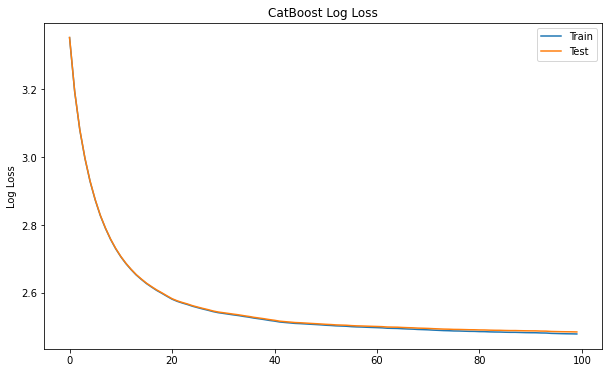

In [53]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x_axis, results['learn']['MultiClass'], label='Train')
ax.plot(x_axis, results['validation']['MultiClass'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('CatBoost Log Loss')
plt.show()

In [54]:
preds  = catboost_final.predict_proba(test)
submission = pd.DataFrame(preds,
                          columns=le2.classes_,
                          index=test.index)
submission.to_csv('CatBoost_final_model.csv', index_label='Id')

In [55]:
!kaggle competitions submit -c sf-crime -f CatBoost_final_model.csv -m "Message"

100% 704M/704M [00:14<00:00, 49.3MB/s]
Successfully submitted to San Francisco Crime Classification